In [307]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
from robot import Robot
from helper_fns import spawn_models
mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact.yaml",
                                   sym_vars = [])

In [231]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from mpc import MPC
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
imp = ImpedanceController(input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs, visc_fric = 100)

mpc_params= yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params = mpc_params, ipopt_options = ipopt_options)
mpc.icem_init(mpc_params)
M_inv = rob.inv_mass_fn(ca.DM.zeros(7))

# for H=5, dt=0.05
# 3.2 ms for 80 samples, symbolic mass
# 1.8 ms for 80 samples, numerical mass
%timeit mpc.robots['free'].rollout(np.zeros(14), np.zeros((3,mpc_params['num_samples']*mpc_params['H'])), M_inv, np.ones(3))
# 3.4 ms for 80 samples w/ ca.DM inputs, 3.9 with numpy inputs, all symbolic mass
# 1.8 ms for 80 smaples, numerical mass
%timeit mpc.robots['free'].rollout_map(ca.DM.zeros((14,1)), ca.DM.ones((3,mpc_params['num_samples']*mpc_params['H'])), M_inv, ca.DM.zeros(3))
#res = mpc.robots['free'].step_vec(ca.DM.zeros((14)), 2*ca.DM.ones((3)), M_inv, 100*ca.DM.ones(3))
#res = mpc.robots['free'].rollout(ca.DM.zeros((14,1)), 1*ca.DM.ones((3,mpc_params['H'])), M_inv, 100*ca.DM.ones(3))
res = mpc.robots['free'].rollout(ca.DM.zeros((14)), np.random.randn(3,mpc_params['num_samples']*mpc_params['H']), M_inv, 100*ca.DM.ones(3))
#print(res)

4.14 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.48 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [359]:
# solve time, mpc 
import time
mpc_params= yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params = mpc_params, ipopt_options = ipopt_options)
N = 100
times = []
costs = []
for _ in range(N):
    params['q'] += 0.05*np.random.randn(7) # perturb initial state
    tic = time.perf_counter()
    cost, _ = mpc.solve(params)
    times.append(time.perf_counter()-tic)
    costs.append(np.squeeze(cost.full()))
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')
print(f'Cost mean: {np.mean(costs)}, cov: {np.cov(costs)}')

Cold start time:  0.3015717000234872 sec
Cold start rate:  3.315961013324915 Hz
Warm start rate: 78.71623518232023 Hz
Cost mean: 0.9620773114252049, cov: 2.5594964385724865e-05


In [ ]:
# solve time, cem 
import time
mpc_params= yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params = mpc_params, ipopt_options = ipopt_options)

N = 50
times = []
costs = []
mpc_params= yaml_load('config/mpc_params.yaml')
mpc.icem_init()
for _ in range(N):
    params['q'] += 0.05*np.random.randn(7) # perturb initial state
    tic = time.perf_counter()
    cost, _ = mpc.icem_solve(params)
    times.append(time.perf_counter()-tic)
    costs.append(np.squeeze(cost.full()))
    
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')
print(f'Cost mean: {np.mean(costs)}, cov: {np.cov(costs)}')

In [361]:
from robot import Robot
from helper_fns import spawn_models
from mpc import MPC

mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact.yaml",
                                   sym_vars = [])
rob = robots['free']
mpc_params = yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params=mpc_params, ipopt_options = ipopt_options)
params = {'q': ca.DM.zeros(7),
          'dq': ca.DM.zeros(7),
          'belief_free':1.0, 
          'imp_stiff':400*ca.DM.ones(3),}
cost, res = mpc.solve(params)
res['imp_stiff'] = params['imp_stiff']
traj = rob.get_ext_state(res)
print(cost)
#print(traj['imp_rest'])
p_mpc = np.squeeze(np.array(traj['p']))
u_mpc = np.squeeze(np.array(traj['imp_rest']))


1.06417


In [358]:
mpc_params = yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params=mpc_params, ipopt_options = ipopt_options)
mpc.icem_init()
# %timeit rob.rollout_map(ca.DM.zeros(14), ca.DM.zeros(3, 6*80), ca.DM.zeros(3))
# w/ map: 53 ms, w/o rollout is 6 ms for H=7
#%timeit mpc.icem_warmstart(ca.DM.zeros(14), mpc_params, rob)
#print(cost)
#print(best_u)
traj_cem = rob.get_ext_state(res)
p_cem = np.squeeze(np.array(traj_cem['p']))
u_cem = np.squeeze(np.array(traj_cem['imp_rest']))
print(cost)

1.86365


Text(0.5, 24.000000000000043, 'Time (sec)')

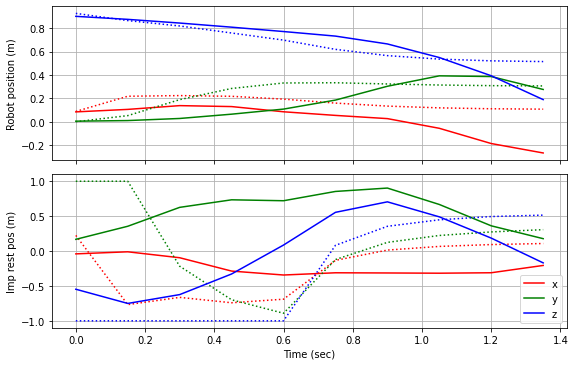

In [304]:
import matplotlib.pyplot as plt
import numpy as np
cols = ['r', 'g', 'b']
labs = ['x', 'y', 'z']

t = [step*mpc_params['dt'] for step in range(mpc_params['H'])]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,5))
for i in range(3):
    col = cols.pop(0)
    lab = labs.pop(0)
    axs[0].plot(t, p_cem[i,:], label=lab, color=col)
    axs[0].plot(t, p_mpc[i,:], color=col, linestyle=':')
    
    axs[1].plot(t, u_cem[i,:], label=lab, color=col)
    axs[1].plot(t, u_mpc[i,:], color=col, linestyle=':')

plt.legend()
plt.tight_layout()
#plt.xlim([0, t[-1]])
axs[0].set_ylabel('Robot position (m)')
axs[1].set_ylabel('Imp rest pos (m)')
axs[1].set_xlabel('Time (sec)')

In [343]:
samps = np.ones((3,70,10))
news = np.ones((3,10,10))
bigsamps = np.ones((3,80,10))
%timeit np.append(samps, news)
%timeit bigsamps[:,:10,:] = news
%timeit samps.clip(0,1, out=samps)
%timeit samps.reshape(3,-1)
print(samps.shape)

3.66 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
622 ns ± 29.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
12.4 µs ± 945 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
170 ns ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
(3, 70, 10)
